In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np  
import os
from glob import glob
import plotly.graph_objects as go


def load_data(path):
    return pd.read_csv(path)


def load_session_file(session_path, animal_name, file_type):
    pattern = os.path.join(session_path, f"{animal_name}_{file_type}_*.csv")
    matches = glob(pattern)
    
    if not matches:
        raise FileNotFoundError(f"No file found for {animal_name} - {file_type}")
    
    if len(matches) > 1:
        print("Multiple matches found, loading the first one:")
    
    print(matches)
    return load_data(matches[0])


In [2]:

Animal = "LPE-15852"
SessionPath = "C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\"
    
print(f"Loading data for animal: {Animal} from session path: {SessionPath}")    
    
StartTriggerData   = load_session_file(SessionPath, Animal, "StartTrigger")
CameraData         = load_session_file(SessionPath, Animal, "CameraData")
CameraTriggerData  = load_session_file(SessionPath, Animal, "CameraTrigger")
NextFileData       = load_session_file(SessionPath, Animal, "NextFileTrigger")
ProjectionData     = load_session_file(SessionPath, Animal, "Projection")
RotaryEncoderData  = load_session_file(SessionPath, Animal, "RotaryEncoder")
RewardData         = load_session_file(SessionPath, Animal, "Reward")

Dataframes = [StartTriggerData, CameraData, CameraTriggerData, 
              NextFileData, ProjectionData, RotaryEncoderData, RewardData]

labels = [
    "StartTriggerData", "CameraData", "CameraTriggerData",
    "NextFileData", "ProjectionData", "RotaryEncoderData", "RewardData"
]

# find the initial timestamp t0
tmin = min([df.iloc[:,0].min() for df in Dataframes])
tmax = max([df.iloc[:,0].max() for df in Dataframes])


print()
print(f"Session duration: {tmax - tmin} seconds")
print(f"Water delivered: {RewardData['WaterDelivered'].iloc[-1]} uL")
print(f"Total rewards: {len(RewardData['Timestamp'])}")
print(f"Rewards: {(RewardData['ManualReward'] == 0).sum()} auto, {(RewardData['ManualReward'] == 1).sum()} manual")
print()
print("Data collected:")
print(f"StartTriggerData: {list(StartTriggerData.columns)}")
print(f"CameraData: {list(CameraData.columns)}")
print(f"CameraTriggerData: {list(CameraTriggerData.columns)}")
print(f"NextFileData: {list(NextFileData.columns)}")    
print(f"ProjectionData: {list(ProjectionData.columns)}")
print(f"RotaryEncoderData: {list(RotaryEncoderData.columns)}")


# remove t0 from all timestamps
for df in Dataframes:
    df.iloc[:,0] = df.iloc[:,0] - tmin




Loading data for animal: LPE-15852 from session path: C:\Users\HugoMarques\Downloads\keremdata\Behavior\
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_StartTrigger_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_CameraData_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_CameraTrigger_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_NextFileTrigger_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_Projection_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_RotaryEncoder_2026-02-09T16_37_11.csv']
['C:\\Users\\HugoMarques\\Downloads\\keremdata\\Behavior\\LPE-15852_Reward_2026-02-09T16_37_11.csv']

Session duration: 1670.4819839997217 seconds
Water delivered: 315 uL
Total rewards: 63
Rewards: 14 auto, 49 manual

Data collected:
StartTriggerData: 

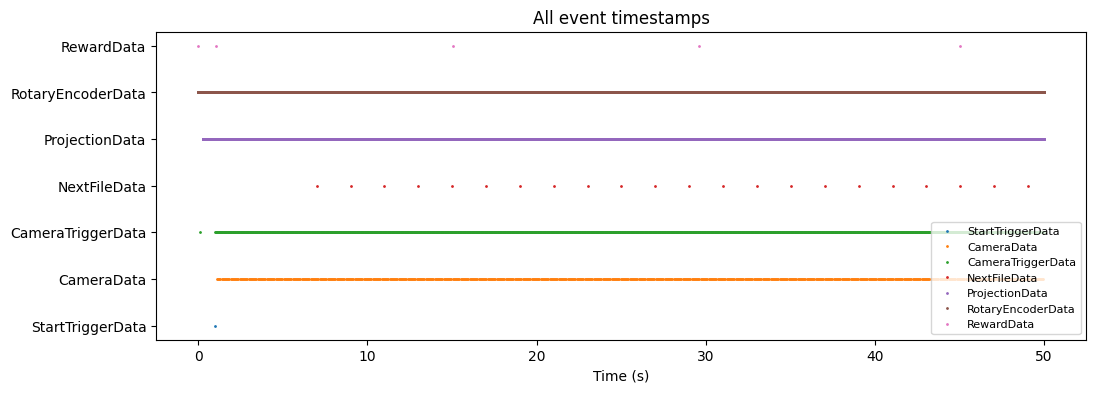

In [ ]:
# plot the first 50 seconds of data

plt.figure(figsize=(12, 4))

for i, df in enumerate(Dataframes):
    # mask for first 50 seconds
    #mask = (df.iloc[:,0] <= 500) & (df.iloc[:,0] >= 0.9)
    mask = (df.iloc[:,0] <= 50)
    plt.plot(
        df.loc[mask, df.columns[0]],  # x-values in seconds
        [i+1] * mask.sum(),           # y-values
        marker='.', linestyle='None', label=labels[i], markersize=2
    )

plt.xlabel("Time (s)")
plt.yticks(range(1, len(Dataframes)+1), labels)
plt.title("First 50 seconds of session data")
plt.legend(loc="lower right", fontsize=8)
plt.show()




In [77]:
ImagingDT = 8.57 # Hz
data = np.load("c:\\Users\\HugoMarques\\Downloads\\Fneu.npy")
print(data.shape)


(209, 6148)


C:\Users\HugoMarques\AppData\Local\Temp\ipykernel_21220\1178958055.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=8)


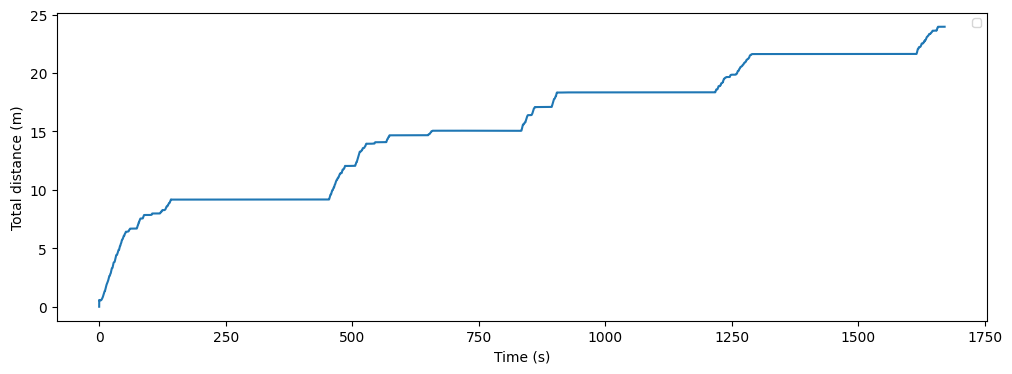

In [4]:
# plot the total distance recorder from the rotary encoder
plt.figure(figsize=(12, 4))

plt.plot(RotaryEncoderData['Timestamp'], RotaryEncoderData['TotalDistance'])
plt.xlabel("Time (s)")
plt.ylabel("Total distance (m)")
plt.legend(loc="upper right", fontsize=8)
plt.show()


In [5]:
# plot licking behavior
merged = pd.merge_asof(
    RewardData[['Timestamp']],
    CameraData[['Timestamp', 'ROIValue']],
    on='Timestamp',
    direction='nearest'
)


fig = go.Figure()

# ROI trace
fig.add_trace(go.Scatter( x=CameraData['Timestamp'], y=CameraData['ROIValue'],
                         mode='lines', name='ROI Value'))

# Reward points
fig.add_trace(go.Scatter(x=merged['Timestamp'], y=merged['ROIValue'],
                         mode='markers', name='Reward', marker=dict(size=8, color='red')))

fig.update_layout(title="Licking and reward", xaxis_title="Time (s)", 
                  yaxis_title="Licking?", legend=dict(x=1, y=1))

fig.show()
